# Use case ideas:
    - Laundry (Binary: running, done)
    - Door lock (Binary: locked, unlocked)
    - Package on porch (Binary: present, not present)
    - Cars (Multi-Binary: A home/away, B home/away)
    - Baby monitor (Multi-class: lying, sitting, out of bed)
    - Weather (Multi-class: clear, rain, snow)
    - Liquid quantity (Regression: # of mL in container)
        - Gelly's water?
    - Light (Regression: Amount of light outside)
        - Ex. 100% (bright day) - 0% (full dark)


# Next Steps:
- Collect some basic initial data
    - 3 use cases (Laundry, Door Lock, Package)
    - 10 sec clips, stationary position/viewpoint
    - 1 clip per variant per category
        - Category = Door Locked vs. Unlocked
        - Variant = Visual variations (lighting, object placement, etc.)
- Data structure:
    - data
        - laundry
            - metadata.json
            - 0/
                - video1.mp4
                - video2.mp4
            - 1/
                - video1.mp4
                - video2.mp4
        - package
            - ...
- Combine code into single pipeline
    - Inputs:
        - dataset_name
        - backbone
        - head
        - frames_per_video
        - img_size
    - Outputs:
        - trained_head
        - overall_accuracy
        - timing_data
    - Backbone
        - Function that imports pre-trained model, applies preprocessing, gets embeddings, returns X and y tensors
- Test with 3 backbones in notebook
- Research more pre-trained models and test
- Experiment with head layers
- Questions to answer:
    - How many frames needed per scenario?
    - Which backbone is best combo of fast and accurate? (Looking to overfit)
    - What layer(s) needed in head?
    - How is this best adapted to multi-class and regression tasks?


# Setup

In [1]:
import torch
from torch import nn
from torchvision import transforms
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
from torchvision.models.feature_extraction import create_feature_extractor
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split
import open_clip
from PIL import Image
import cv2
import numpy as np
from pathlib import Path
import glob
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Data Import

In [2]:
def import_data(dataset_name, num_frames=30, target_size=(224, 224)):
    """
    Import frames and their labels from raw video files
    
    Args:
        dataset_name: Name of dataset/task
        num_frames: Frame limit to import from each individual video file
        target_size: Target dimensions of each video frame
    
    Returns:
        List[PIL.Image]: All video frames to be used for training
        List[int]: Labels corresponding to each video frame
    """
    base_path = f"data/{dataset_name}"
    cats = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
    frames = []
    labels = []
    
    for cat in cats:
        cat_path = os.path.join(base_path, cat)
        files = [f for f in os.listdir(cat_path) if f.endswith(".mp4")]
        files = [os.path.join(cat_path, f) for f in files]

        
        for file in files:
            print(f"Loading file: {file}")

            cap = cv2.VideoCapture(str(file))
            
            if not cap.isOpened():
                print(f"Error: Could not open {file}")
                continue
                
            frame_count = 0
            video_frames = []
            video_labels = []
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                    
                # Basic preprocessing
                frame = cv2.resize(frame, target_size)
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                pil_image = Image.fromarray(frame)
                
                video_frames.append(pil_image)
                video_labels.append(int(cat))
                frame_count += 1
                
                if (num_frames > 0) & (frame_count >= num_frames):
                    break
            
            print(f"-- Frames loaded: {len(video_frames)}")
            print(f"-- Label assigned: {cat}")

            frames += video_frames
            labels += video_labels
            cap.release()
    
    assert len(frames) == len(labels)
    vals, counts = np.unique(labels, return_counts=True)
    print(f"Total frames loaded: {len(frames)}")
    for v, c in zip(vals, counts):
        print(f"-- {v}: {c}")

    return frames, labels


# Backbones

In [3]:
def bb_clip(frames, labels, dataset_name, force_calc=False):
    filename = f"features/{dataset_name}_clip.pt"
    if os.path.exists(filename) & (not force_calc):
        print("Importing saved features")
        data = torch.load(filename)
        X, y = data["X"], data["y"]

    else:
        print("Generating and saving features")
        model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16', pretrained='openai')
        model.eval()

        feats = []
        for img in tqdm(frames):
            img_prep = preprocess(img).unsqueeze(0)
            with torch.no_grad():
                img_feats = model.encode_image(img_prep)   # (1, 512)
                img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)
                feats.append(img_feats)

        X = torch.cat(feats, dim=0)
        y = torch.tensor(labels)
        torch.save({"X": X, "y": y}, filename)

    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")

    return X, y


In [4]:
backbones = {
    "clip": bb_clip
}

# Model Prep

In [5]:
def prepare_objects(X, y):
    idx = np.arange(len(y))
    train_idx, val_idx = train_test_split(
        idx,
        test_size=0.2,
        shuffle=True,
        stratify=y,
        random_state=314
    )

    print(f"Training Size: {len(train_idx)}")
    print(f"Validation Size: {len(val_idx)}")

    train_X, val_X = X[train_idx], X[val_idx]
    train_y, val_y = y[train_idx], y[val_idx]

    train_ds = TensorDataset(train_X, train_y)
    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)

    val_ds = TensorDataset(val_X, val_y)
    val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)

    model = nn.Linear(X.shape[1], 2)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    return train_loader, val_loader, model, optimizer, criterion


# Training/Eval

In [6]:
def train_one_epoch(model, data_loader, criterion, optimizer):
    model.train()
    train_loss = 0
    n = 0
    for feats, labels in data_loader:
        optimizer.zero_grad()
        logits = model(feats)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * labels.size(0)
        n += labels.size(0)

    train_loss /= n

    return model, train_loss


def eval_one_epoch(model, data_loader):
    model.eval()
    correct = 0
    n = 0
    with torch.no_grad():
        for feats, labels in data_loader:
            preds = model(feats).argmax(dim=1)
            correct += (preds == labels).sum().item()
            n += labels.size(0)

    val_acc = correct / n

    return val_acc


def train(
    train_loader,
    val_loader,
    model,
    optimizer,
    criterion,
    num_epochs
):
    preds_all = []
    for epoch in tqdm(range(num_epochs)):
        model, train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
        val_acc = eval_one_epoch(model, val_loader)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Acc: {val_acc:.3f}")

    return model


def test(model, X, y):
    # Total accuracy (train + val)
    model.eval()
    total = y.shape[0]
    with torch.no_grad():
        preds = model(X).argmax(dim=1)
        correct = (preds == y).sum().item()

    test_acc = correct / total
    print(f"\n-- Overall Accuracy: {correct}/{total} ({round(100*test_acc, 1)}%)")


# Main

In [10]:
def main(dataset_name, backbone, num_frames, num_epochs):

    frames, labels = import_data(dataset_name, num_frames=num_frames)
    X, y = backbones[backbone](frames, labels, dataset_name=dataset_name, force_calc=True)
    train_loader, val_loader, model, optimizer, criterion = prepare_objects(X, y)
    model = train(
        train_loader=train_loader,
        val_loader=val_loader,
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        num_epochs=num_epochs
    )

    test(model, X, y)

    return model

# Full Test

In [11]:
def full_test(dataset_name, backbone, model):
    frames, labels = import_data(dataset_name, num_frames=-1)
    X, y = backbones[backbone](frames, labels, dataset_name=dataset_name, force_calc=True)
    test(model, X, y)

# Execute

In [18]:
dataset_name = "lock"
backbone = "clip"
num_frames = 30
num_epochs = 1000

model = main(dataset_name, backbone, num_frames, num_epochs)

Loading file: data/lock/0/video0.mp4
-- Frames loaded: 30
-- Label assigned: 0
Loading file: data/lock/0/video1.mp4
-- Frames loaded: 30
-- Label assigned: 0
Loading file: data/lock/1/video0.mp4
-- Frames loaded: 30
-- Label assigned: 1
Loading file: data/lock/1/video1.mp4
-- Frames loaded: 30
-- Label assigned: 1
Total frames loaded: 120
-- 0: 60
-- 1: 60
Generating and saving features


100%|██████████| 120/120 [00:06<00:00, 17.66it/s]


X shape: torch.Size([120, 512])
y shape: torch.Size([120])
Training Size: 96
Validation Size: 24


  9%|▉         | 93/1000 [00:00<00:00, 927.89it/s]

Epoch 1/1000 - Train Loss: 0.6944 - Val Acc: 0.625
Epoch 2/1000 - Train Loss: 0.6906 - Val Acc: 0.667
Epoch 3/1000 - Train Loss: 0.6878 - Val Acc: 0.583
Epoch 4/1000 - Train Loss: 0.6852 - Val Acc: 0.667
Epoch 5/1000 - Train Loss: 0.6818 - Val Acc: 0.583
Epoch 6/1000 - Train Loss: 0.6791 - Val Acc: 0.750
Epoch 7/1000 - Train Loss: 0.6762 - Val Acc: 0.750
Epoch 8/1000 - Train Loss: 0.6734 - Val Acc: 0.792
Epoch 9/1000 - Train Loss: 0.6706 - Val Acc: 0.750
Epoch 10/1000 - Train Loss: 0.6677 - Val Acc: 0.708
Epoch 11/1000 - Train Loss: 0.6650 - Val Acc: 0.750
Epoch 12/1000 - Train Loss: 0.6621 - Val Acc: 0.750
Epoch 13/1000 - Train Loss: 0.6595 - Val Acc: 0.667
Epoch 14/1000 - Train Loss: 0.6567 - Val Acc: 0.708
Epoch 15/1000 - Train Loss: 0.6538 - Val Acc: 0.708
Epoch 16/1000 - Train Loss: 0.6514 - Val Acc: 0.708
Epoch 17/1000 - Train Loss: 0.6486 - Val Acc: 0.708
Epoch 18/1000 - Train Loss: 0.6457 - Val Acc: 0.708
Epoch 19/1000 - Train Loss: 0.6431 - Val Acc: 0.708
Epoch 20/1000 - Train

 20%|█▉        | 196/1000 [00:00<00:00, 985.82it/s]

Epoch 183/1000 - Train Loss: 0.3706 - Val Acc: 0.917
Epoch 184/1000 - Train Loss: 0.3695 - Val Acc: 0.917
Epoch 185/1000 - Train Loss: 0.3684 - Val Acc: 0.917
Epoch 186/1000 - Train Loss: 0.3673 - Val Acc: 0.917
Epoch 187/1000 - Train Loss: 0.3662 - Val Acc: 0.917
Epoch 188/1000 - Train Loss: 0.3658 - Val Acc: 0.917
Epoch 189/1000 - Train Loss: 0.3642 - Val Acc: 0.917
Epoch 190/1000 - Train Loss: 0.3633 - Val Acc: 0.917
Epoch 191/1000 - Train Loss: 0.3624 - Val Acc: 0.917
Epoch 192/1000 - Train Loss: 0.3612 - Val Acc: 0.917
Epoch 193/1000 - Train Loss: 0.3602 - Val Acc: 0.917
Epoch 194/1000 - Train Loss: 0.3591 - Val Acc: 0.917
Epoch 195/1000 - Train Loss: 0.3583 - Val Acc: 0.917
Epoch 196/1000 - Train Loss: 0.3571 - Val Acc: 0.917


 30%|██▉       | 295/1000 [00:00<00:00, 983.09it/s]

Epoch 197/1000 - Train Loss: 0.3561 - Val Acc: 0.917
Epoch 198/1000 - Train Loss: 0.3551 - Val Acc: 0.917
Epoch 199/1000 - Train Loss: 0.3542 - Val Acc: 0.917
Epoch 200/1000 - Train Loss: 0.3537 - Val Acc: 0.917
Epoch 201/1000 - Train Loss: 0.3524 - Val Acc: 0.917
Epoch 202/1000 - Train Loss: 0.3512 - Val Acc: 0.917
Epoch 203/1000 - Train Loss: 0.3504 - Val Acc: 0.917
Epoch 204/1000 - Train Loss: 0.3498 - Val Acc: 0.917
Epoch 205/1000 - Train Loss: 0.3485 - Val Acc: 0.917
Epoch 206/1000 - Train Loss: 0.3474 - Val Acc: 0.917
Epoch 207/1000 - Train Loss: 0.3465 - Val Acc: 0.917
Epoch 208/1000 - Train Loss: 0.3455 - Val Acc: 0.917
Epoch 209/1000 - Train Loss: 0.3444 - Val Acc: 0.917
Epoch 210/1000 - Train Loss: 0.3441 - Val Acc: 0.917
Epoch 211/1000 - Train Loss: 0.3426 - Val Acc: 0.917
Epoch 212/1000 - Train Loss: 0.3419 - Val Acc: 0.917
Epoch 213/1000 - Train Loss: 0.3408 - Val Acc: 0.917
Epoch 214/1000 - Train Loss: 0.3398 - Val Acc: 0.917
Epoch 215/1000 - Train Loss: 0.3388 - Val Acc:

 50%|████▉     | 497/1000 [00:00<00:00, 903.09it/s]

Epoch 357/1000 - Train Loss: 0.2361 - Val Acc: 1.000
Epoch 358/1000 - Train Loss: 0.2357 - Val Acc: 1.000
Epoch 359/1000 - Train Loss: 0.2349 - Val Acc: 1.000
Epoch 360/1000 - Train Loss: 0.2344 - Val Acc: 1.000
Epoch 361/1000 - Train Loss: 0.2338 - Val Acc: 1.000
Epoch 362/1000 - Train Loss: 0.2332 - Val Acc: 1.000
Epoch 363/1000 - Train Loss: 0.2326 - Val Acc: 1.000
Epoch 364/1000 - Train Loss: 0.2321 - Val Acc: 1.000
Epoch 365/1000 - Train Loss: 0.2316 - Val Acc: 1.000
Epoch 366/1000 - Train Loss: 0.2310 - Val Acc: 1.000
Epoch 367/1000 - Train Loss: 0.2305 - Val Acc: 1.000
Epoch 368/1000 - Train Loss: 0.2299 - Val Acc: 1.000
Epoch 369/1000 - Train Loss: 0.2293 - Val Acc: 1.000
Epoch 370/1000 - Train Loss: 0.2289 - Val Acc: 1.000
Epoch 371/1000 - Train Loss: 0.2283 - Val Acc: 1.000
Epoch 372/1000 - Train Loss: 0.2277 - Val Acc: 1.000
Epoch 373/1000 - Train Loss: 0.2274 - Val Acc: 1.000
Epoch 374/1000 - Train Loss: 0.2268 - Val Acc: 1.000
Epoch 375/1000 - Train Loss: 0.2262 - Val Acc:

 70%|███████   | 700/1000 [00:00<00:00, 961.14it/s]

Epoch 561/1000 - Train Loss: 0.1495 - Val Acc: 1.000
Epoch 562/1000 - Train Loss: 0.1491 - Val Acc: 1.000
Epoch 563/1000 - Train Loss: 0.1488 - Val Acc: 1.000
Epoch 564/1000 - Train Loss: 0.1485 - Val Acc: 1.000
Epoch 565/1000 - Train Loss: 0.1481 - Val Acc: 1.000
Epoch 566/1000 - Train Loss: 0.1478 - Val Acc: 1.000
Epoch 567/1000 - Train Loss: 0.1475 - Val Acc: 1.000
Epoch 568/1000 - Train Loss: 0.1472 - Val Acc: 1.000
Epoch 569/1000 - Train Loss: 0.1469 - Val Acc: 1.000
Epoch 570/1000 - Train Loss: 0.1466 - Val Acc: 1.000
Epoch 571/1000 - Train Loss: 0.1463 - Val Acc: 1.000
Epoch 572/1000 - Train Loss: 0.1461 - Val Acc: 1.000
Epoch 573/1000 - Train Loss: 0.1457 - Val Acc: 1.000
Epoch 574/1000 - Train Loss: 0.1453 - Val Acc: 1.000
Epoch 575/1000 - Train Loss: 0.1450 - Val Acc: 1.000
Epoch 576/1000 - Train Loss: 0.1448 - Val Acc: 1.000
Epoch 577/1000 - Train Loss: 0.1444 - Val Acc: 1.000
Epoch 578/1000 - Train Loss: 0.1443 - Val Acc: 1.000
Epoch 579/1000 - Train Loss: 0.1439 - Val Acc:

 90%|█████████ | 902/1000 [00:00<00:00, 985.55it/s]

Epoch 765/1000 - Train Loss: 0.0985 - Val Acc: 1.000
Epoch 766/1000 - Train Loss: 0.0984 - Val Acc: 1.000
Epoch 767/1000 - Train Loss: 0.0982 - Val Acc: 1.000
Epoch 768/1000 - Train Loss: 0.0980 - Val Acc: 1.000
Epoch 769/1000 - Train Loss: 0.0978 - Val Acc: 1.000
Epoch 770/1000 - Train Loss: 0.0976 - Val Acc: 1.000
Epoch 771/1000 - Train Loss: 0.0974 - Val Acc: 1.000
Epoch 772/1000 - Train Loss: 0.0972 - Val Acc: 1.000
Epoch 773/1000 - Train Loss: 0.0970 - Val Acc: 1.000
Epoch 774/1000 - Train Loss: 0.0968 - Val Acc: 1.000
Epoch 775/1000 - Train Loss: 0.0966 - Val Acc: 1.000
Epoch 776/1000 - Train Loss: 0.0964 - Val Acc: 1.000
Epoch 777/1000 - Train Loss: 0.0963 - Val Acc: 1.000
Epoch 778/1000 - Train Loss: 0.0960 - Val Acc: 1.000
Epoch 779/1000 - Train Loss: 0.0959 - Val Acc: 1.000
Epoch 780/1000 - Train Loss: 0.0957 - Val Acc: 1.000
Epoch 781/1000 - Train Loss: 0.0956 - Val Acc: 1.000
Epoch 782/1000 - Train Loss: 0.0954 - Val Acc: 1.000
Epoch 783/1000 - Train Loss: 0.0953 - Val Acc:

100%|██████████| 1000/1000 [00:01<00:00, 956.05it/s]


Epoch 968/1000 - Train Loss: 0.0668 - Val Acc: 1.000
Epoch 969/1000 - Train Loss: 0.0666 - Val Acc: 1.000
Epoch 970/1000 - Train Loss: 0.0665 - Val Acc: 1.000
Epoch 971/1000 - Train Loss: 0.0664 - Val Acc: 1.000
Epoch 972/1000 - Train Loss: 0.0663 - Val Acc: 1.000
Epoch 973/1000 - Train Loss: 0.0662 - Val Acc: 1.000
Epoch 974/1000 - Train Loss: 0.0660 - Val Acc: 1.000
Epoch 975/1000 - Train Loss: 0.0659 - Val Acc: 1.000
Epoch 976/1000 - Train Loss: 0.0658 - Val Acc: 1.000
Epoch 977/1000 - Train Loss: 0.0657 - Val Acc: 1.000
Epoch 978/1000 - Train Loss: 0.0656 - Val Acc: 1.000
Epoch 979/1000 - Train Loss: 0.0654 - Val Acc: 1.000
Epoch 980/1000 - Train Loss: 0.0653 - Val Acc: 1.000
Epoch 981/1000 - Train Loss: 0.0652 - Val Acc: 1.000
Epoch 982/1000 - Train Loss: 0.0651 - Val Acc: 1.000
Epoch 983/1000 - Train Loss: 0.0649 - Val Acc: 1.000
Epoch 984/1000 - Train Loss: 0.0648 - Val Acc: 1.000
Epoch 985/1000 - Train Loss: 0.0647 - Val Acc: 1.000
Epoch 986/1000 - Train Loss: 0.0646 - Val Acc:

In [19]:
full_test(dataset_name, backbone, model)

Loading file: data/lock/0/video0.mp4
-- Frames loaded: 307
-- Label assigned: 0
Loading file: data/lock/0/video1.mp4
-- Frames loaded: 312
-- Label assigned: 0
Loading file: data/lock/1/video0.mp4
-- Frames loaded: 314
-- Label assigned: 1
Loading file: data/lock/1/video1.mp4
-- Frames loaded: 305
-- Label assigned: 1
Total frames loaded: 1238
-- 0: 619
-- 1: 619
Generating and saving features


/opt/miniconda3/envs/monitor/lib/python3.10/site-packages/open_clip/factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(
100%|██████████| 1238/1238 [01:06<00:00, 18.72it/s]

X shape: torch.Size([1238, 512])
y shape: torch.Size([1238])

-- Overall Accuracy: 908/1238 (73.3%)


- Laundry: 99.7%
- Package: 96.9%
- Lock: 72.1%

# Displaying test results

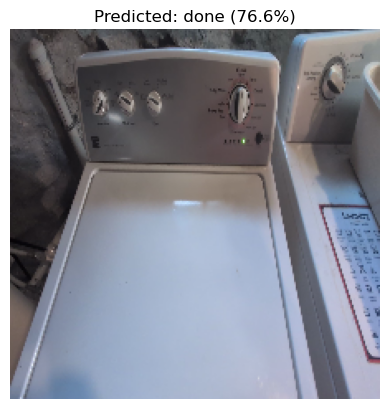

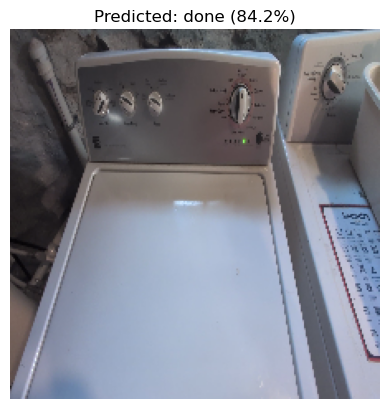

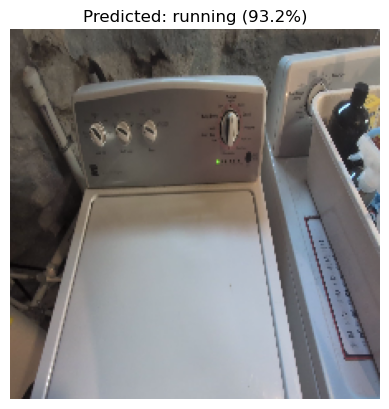

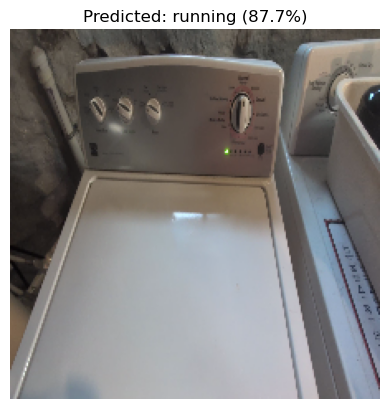

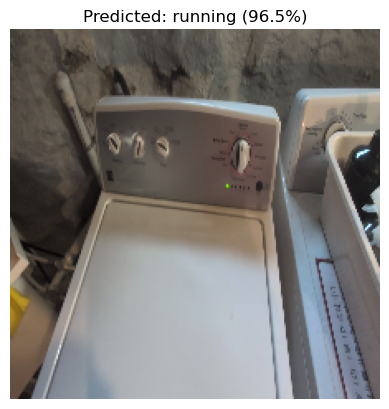

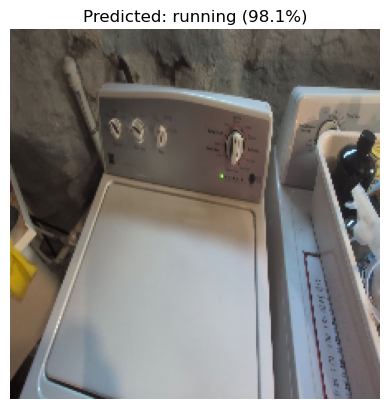

In [112]:
# for i in [0, 494, 841, 1103, 1147]:
for i in [0, 80, 841, 1073, 1103, 1147]:
    test_img = images[i]

    img_prep = preprocess(test_img).unsqueeze(0)
    with torch.no_grad():
        img_feats = model.encode_image(img_prep)   # (1, 512)
        img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)

    classifier.eval()
    with torch.no_grad():
        logits = classifier(img_feats)
        probs = torch.softmax(logits, dim=1)
        pred_class = probs.argmax(dim=1).item()

    labels = ["running", "done"]

    plt.imshow(test_img)
    plt.axis("off")
    plt.title(f"Predicted: {labels[pred_class]} ({100*probs[0, pred_class]:.1f}%)")
    plt.show()

In [65]:
preds

tensor([0, 0, 0, 0, 0])

In [41]:
# # Load models
# vits = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
# vitb = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
# vits.eval(); vitb.eval()

# # DINOv2-preferred preprocessing for ViT-14 backbones (224 works well for many use-cases)
# preprocess = transforms.Compose([
#     transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
# ])

# img = preprocess(images_done_512[0]).unsqueeze(0)
# with torch.no_grad():
#     feats_s = vits(img)  # token/cls output depending on config; typically use [:,0] for CLS if needed
#     feats_b = vitb(img)
#     # If output is token embeddings, take CLS token:
#     if feats_s.dim() == 3: feats_s = feats_s[:,0]
#     if feats_b.dim() == 3: feats_b = feats_b[:,0]

# print(feats_s.shape)
# print(feats_b.shape)

In [42]:
# weights = MobileNet_V3_Large_Weights.IMAGENET1K_V2
# model = mobilenet_v3_large(weights=weights).eval()

# # Get a backbone that returns penultimate features
# backbone = create_feature_extractor(model, return_nodes={'avgpool': 'feat'})  # 960-d pooled features

# preprocess = weights.transforms()
# img = preprocess(images_done_512[0]).unsqueeze(0)

# with torch.no_grad():
#     out = backbone(img)['feat']      # shape: (1, 960, 1, 1)
#     feats = out.flatten(1)           # (1, 960)

# feats.shape